# Setup

We will only run a few of the examples from this chapter. The majority of the chapter has important conceptual information, but nothing really new from a code perpsective.

In [198]:
import pandas as pd

from scipy.stats import norm
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({"font.family":"Arial", 
                     "font.size": 10 ,
                     "axes.labelweight": "bold",
                     "axes.titleweight": "bold",
                     "legend.frameon": False,
                     "text.latex.preamble": r'\boldmath'})


# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5)


# Helper function for changing tick label fonts. Not sure an easier way to do this but there must be one...
def change_label_font(ax,fontname="Arial"):
        
        def change_font(thisax):
                for label in thisax.get_xticklabels():
                        label.set_fontproperties(fontname)
                for label in thisax.get_yticklabels():
                        label.set_fontproperties(fontname)       
                return thisax

        if type(ax) == mpl.axes._axes.Axes:
                ax = change_font(ax)
        elif type(ax) == np.ndarray:
                shp = ax.shape
                ax = ax.ravel()
                tempax = []
                for thisax in ax:
                        tempax.append(change_font(thisax))
                ax = np.reshape(np.array(tempax),(shp[0],-1))
                        
        else:
                print("No axis provided. Returning original axis.")

        return ax

        

In [51]:
data = pd.read_csv("./data/WaffleDivorce.csv",sep=';')
data["WaffleHousesPerMillion"] = data["WaffleHouses"] / data["Population"]
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,WaffleHousesPerMillion
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,26.778243
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,2.843602
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,14.041096
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.000000



## Figure 5.1

We are cheating a little here and using the built in linear regression function in `seaborn`, which uses `statsmodels` on the back end. If we were to build a Bayesian model then it would look like the ones from Chapter 4. 


$$
\begin{align*}
h_i & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = \alpha + \beta(x_i - \bar{x})\\
\alpha & \sim \text{Normal}(0,0.2)\\
\beta & \sim \text{Normal}(0,0.5)\\
\sigma & \sim \text{Exponential}(1)\\
\end{align*}
$$



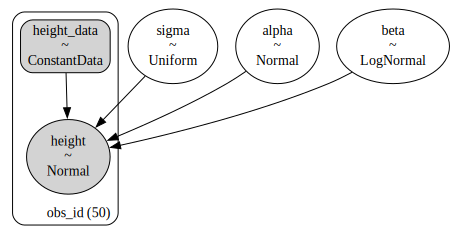

In [225]:
with pm.Model() as model:

    # Data
    wafflehouse_data = pm.ConstantData("height_data",data["WaffleHousesPerMillion"],dims="obs_id")

    # Priors
    alpha    = pm.Normal('alpha',0,10)
    beta     = pm.LogNormal('beta' , 0, 1)
    sigma    = pm.Uniform('sigma',0,50)

    # Linear model
    mu = alpha + beta*wafflehouse_data

    # Likelihood
    divorce = pm.Normal("height",mu=mu, sigma=sigma,observed=data["Divorce"],dims="obs_id")

pm.model_to_graphviz(model)
    

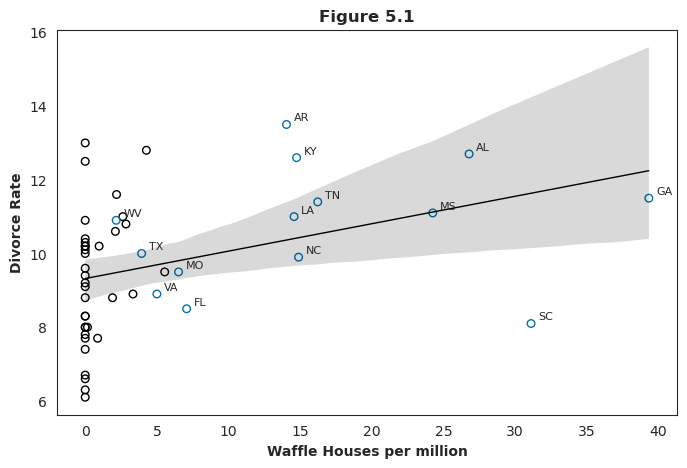

In [82]:
with sns.axes_style("white"):

    # Make figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()

    # Plot data
    colors = {"1": blue_cb, "0": "black"}
    ax.scatter(
               data["WaffleHousesPerMillion"], 
               data["Divorce"],
               facecolors='none',
               color=(0,0,0,0),
               edgecolors=data["South"].apply(lambda x: colors[str(x)]),
               s=30
               )
    
    # Fit regression
    sns.regplot(data=data, x="WaffleHousesPerMillion", y="Divorce", scatter=False, color='k', line_kws= {"lw": 1})

    # Set labels
    ax.set(xlabel="Waffle Houses per million",
           ylabel="Divorce Rate",
           title="Figure 5.1")
    
    for row in data[data.South == 1].itertuples():
       ax.annotate(row.Loc,(row.WaffleHousesPerMillion+.5,row.Divorce+.1),fontsize=8)

# Section 5.1 Spurious Association

## Figure 5.2

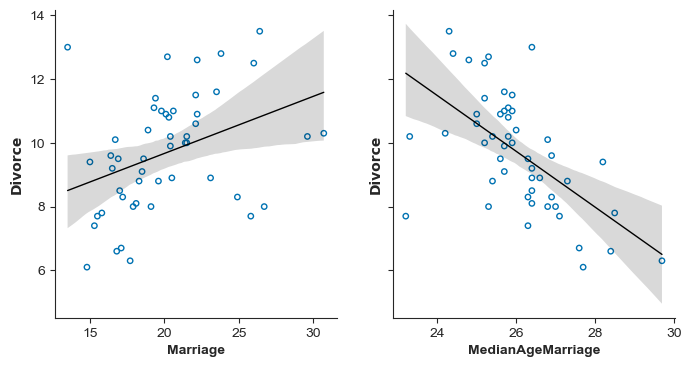

In [212]:
with sns.axes_style("ticks"):
    
    # Make figure
    fig, ax = plt.subplots(1,2,sharey=True, sharex=False)
    fig.set_size_inches(8,4)

    # Left ax
    ax[0].scatter(data.Marriage, data.Divorce, edgecolors=blue_cb, facecolors='none',s=15)
    ax[0].set_xlabel("Marriage Rate",fontname="Arial")
    sns.regplot(ax=ax[0],data=data,x="Marriage",y="Divorce",scatter=False, color='k', line_kws= {"lw": 1})

    # Right ax
    ax[1].scatter(data.MedianAgeMarriage, data.Divorce, edgecolors=blue_cb, facecolors='none',s=15)
    ax[1].set_xlabel("Median Age Marriagee",fontname="Arial")
    sns.regplot(ax=ax[1],data=data,x="MedianAgeMarriage",y="Divorce",scatter=False, color='k', line_kws= {"lw": 1})
    
    # Clean up    
    ax = change_label_font(ax)
    sns.despine()#offset=5, trim=True)

## Multiple regresion Notation

In [229]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

milk = pd.read_csv('./data/milk.csv',sep=';').dropna(subset=["neocortex.perc"])

milk = pd.concat([milk, 
                  milk[["kcal.per.g","mass","neocortex.perc","perc.fat","perc.lactose","perc.protein"]].transform(standardize).add_suffix("_zscore")],
                  axis=1)

milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,kcal.per.g_zscore,mass_zscore,neocortex.perc_zscore,perc.fat_zscore,perc.lactose_zscore,perc.protein_zscore
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.969623,-0.622824,-2.080196,-1.323562,1.494180,-0.149200
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.085298,-0.482889,-0.508641,-1.009392,0.553454,1.308338
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.564763,-0.477801,-0.508641,-0.435454,-0.058974,1.286904
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.343864,-0.599078,0.010742,1.179597,-1.243346,-0.081325
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.517376,-0.676678,0.213470,0.987151,-1.515700,1.085063


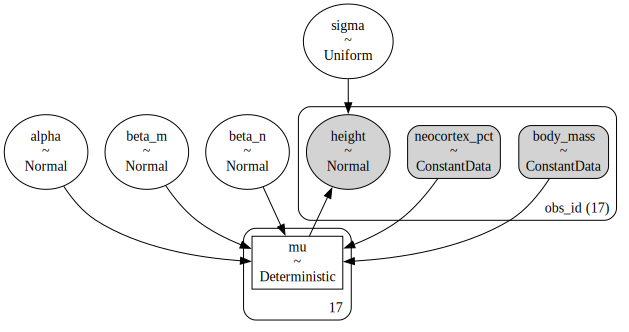

In [232]:
with pm.Model() as multipleregression_model:

    # Data
    body_mass     = pm.ConstantData("body_mass"     , milk["mass_zscore"]           , dims="obs_id")
    neocortex_pct = pm.ConstantData("neocortex_pct" , milk["neocortex.perc_zscore"] , dims="obs_id")

    # Priors
    alpha    = pm.Normal('alpha',0,0.2)
    beta_m   = pm.Normal('beta_m' , 0, 0.5) 
    beta_n   = pm.Normal('beta_n' , 0, 0.5)
    sigma    = pm.Uniform('sigma',0,50)

    # Linear model
    mu = pm.Deterministic('mu',alpha + beta_n*neocortex_pct + beta_m*body_mass)
    
    # Likelihood
    height = pm.Normal("height",mu=mu, sigma=sigma,observed=milk["kcal.per.g_zscore"],dims="obs_id")

pm.model_to_graphviz(multipleregression_model)
    

In [233]:
with multipleregression_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_m, beta_n, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [237]:
az.summary(trace,var_names=["alpha","beta_m","beta_n","sigma"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0005,0.1482,-0.2754,0.2849,0.0018,0.0017,7118.0780,5808.4441,1.0003
beta_m,-0.4850,0.2569,-0.9664,-0.0097,0.0035,0.0025,5350.2905,5237.1010,1.0004
beta_n,0.3681,0.2547,-0.0980,0.8638,0.0036,0.0026,5013.9612,4690.9544,1.0016
sigma,0.9370,0.1963,0.6299,1.3262,0.0026,0.0019,5930.7201,5276.4041,1.0006


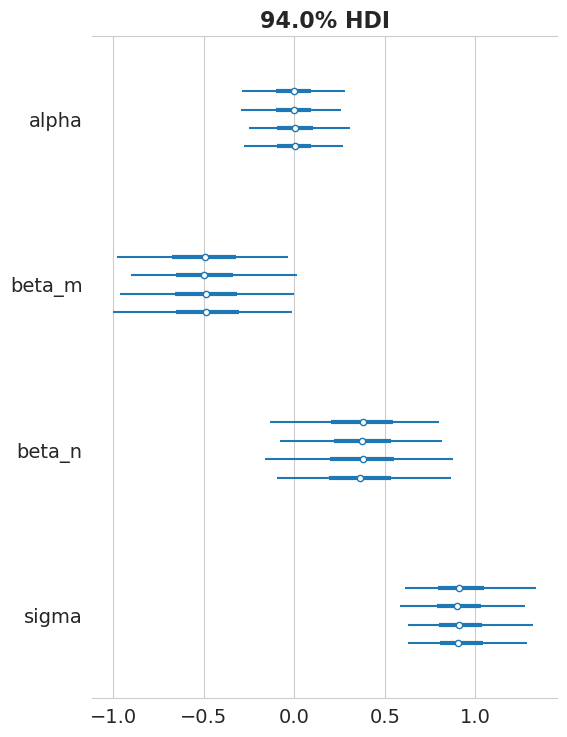

In [240]:
with sns.axes_style("whitegrid"):
    az.plot_forest(trace, var_names=["alpha","beta_m","beta_n","sigma"]);